In [2]:
import IPython.display as display

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (12, 12)
mpl.rcParams['axes.grid'] = False

import numpy as np
import PIL.Image
import os
import time
import tensorflow as tf
import functools

In [3]:
def tensor_to_image(tensor):
  tensor = tensor*255
  tensor = np.array(tensor, dtype=np.uint8)
  if np.ndim(tensor)>3:
    assert tensor.shape[0] == 1
    tensor = tensor[0]
  return PIL.Image.fromarray(tensor)

In [4]:
def load_img(path_to_img):
  max_dim = 512
  img = tf.io.read_file(path_to_img)
  img = tf.image.decode_image(img, channels=3)
  img = tf.image.convert_image_dtype(img, tf.float32)

  shape = tf.cast(tf.shape(img)[:-1], tf.float32)
  long_dim = max(shape)
  scale = max_dim / long_dim

  new_shape = tf.cast(shape * scale, tf.int32)

  img = tf.image.resize(img, new_shape)
  img = img[tf.newaxis, :]
  return img

In [5]:
def imshow(image, title=None):
  if len(image.shape) > 3:
    image = tf.squeeze(image, axis=0)

  plt.imshow(image)
  if title:
    plt.title(title)

In [6]:
vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')

print()
for layer in vgg.layers:
  print(layer.name)


input_layer
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_conv4
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_conv4
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_conv4
block5_pool


In [46]:
content_layers = ['block3_conv3']

style_layers = ['block1_conv1',
                'block2_conv1',
                'block2_conv2',
                'block3_conv1',
                'block3_conv3',
                'block4_conv3',
                'block4_conv3',
                'block5_conv3']

num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

In [47]:
def vgg_layers(layer_names):
  """ Creates a vgg model that returns a list of intermediate output values."""
  # Load our model. Load pretrained VGG, trained on imagenet data
  vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
  vgg.trainable = False
  
  outputs = [vgg.get_layer(name).output for name in layer_names]

  model = tf.keras.Model([vgg.input], outputs)
  return model

In [48]:
content_image = load_img(r"C:\Users\Avishi\Downloads\WhatsApp Image 2024-05-10 at 10.01.19 PM.jpeg")
style_image = load_img(r"C:\Users\Avishi\Downloads\paper.jpg")

In [49]:
style_extractor = vgg_layers(style_layers)
style_outputs = style_extractor(style_image*255)

#Look at the statistics of each layer's output
for name, output in zip(style_layers, style_outputs):
  print(name)
  print("  shape: ", output.numpy().shape)
  print("  min: ", output.numpy().min())
  print("  max: ", output.numpy().max())
  print("  mean: ", output.numpy().mean())
  print()

block1_conv1
  shape:  (1, 286, 512, 64)
  min:  0.0
  max:  820.5923
  mean:  32.33109

block2_conv1
  shape:  (1, 143, 256, 128)
  min:  0.0
  max:  3081.174
  mean:  170.3479

block2_conv2
  shape:  (1, 143, 256, 128)
  min:  0.0
  max:  7139.1904
  mean:  137.47096

block3_conv1
  shape:  (1, 71, 128, 256)
  min:  0.0
  max:  9374.215
  mean:  122.045746

block3_conv3
  shape:  (1, 71, 128, 256)
  min:  0.0
  max:  5782.568
  mean:  345.43512

block4_conv3
  shape:  (1, 35, 64, 512)
  min:  0.0
  max:  7291.107
  mean:  153.17104

block4_conv3
  shape:  (1, 35, 64, 512)
  min:  0.0
  max:  7291.107
  mean:  153.17104

block5_conv3
  shape:  (1, 17, 32, 512)
  min:  0.0
  max:  230.42505
  mean:  4.25647



In [50]:
def gram_matrix(input_tensor):
  result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
  input_shape = tf.shape(input_tensor)
  num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)
  return result/(num_locations)

In [51]:
class StyleContentModel(tf.keras.models.Model):
  def __init__(self, style_layers, content_layers):
    super(StyleContentModel, self).__init__()
    self.vgg = vgg_layers(style_layers + content_layers)
    self.style_layers = style_layers
    self.content_layers = content_layers
    self.num_style_layers = len(style_layers)
    self.vgg.trainable = False

  def call(self, inputs):
    "Expects float input in [0,1]"
    inputs = inputs*255.0
    preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs)
    outputs = self.vgg(preprocessed_input)
    style_outputs, content_outputs = (outputs[:self.num_style_layers],
                                      outputs[self.num_style_layers:])

    style_outputs = [gram_matrix(style_output)
                     for style_output in style_outputs]

    content_dict = {content_name: value
                    for content_name, value
                    in zip(self.content_layers, content_outputs)}

    style_dict = {style_name: value
                  for style_name, value
                  in zip(self.style_layers, style_outputs)}

    return {'content': content_dict, 'style': style_dict}

In [52]:
extractor = StyleContentModel(style_layers, content_layers)

results = extractor(tf.constant(content_image))

print('Styles:')
for name, output in sorted(results['style'].items()):
  print("  ", name)
  print("    shape: ", output.numpy().shape)
  print("    min: ", output.numpy().min())
  print("    max: ", output.numpy().max())
  print("    mean: ", output.numpy().mean())
  print()

print("Contents:")
for name, output in sorted(results['content'].items()):
  print("  ", name)
  print("    shape: ", output.numpy().shape)
  print("    min: ", output.numpy().min())
  print("    max: ", output.numpy().max())
  print("    mean: ", output.numpy().mean())


Styles:
   block1_conv1
    shape:  (1, 64, 64)
    min:  0.003425424
    max:  26112.07
    mean:  323.6088

   block2_conv1
    shape:  (1, 128, 128)
    min:  0.0
    max:  41065.062
    mean:  8428.71

   block2_conv2
    shape:  (1, 128, 128)
    min:  0.02829936
    max:  147382.84
    mean:  5795.248

   block3_conv1
    shape:  (1, 256, 256)
    min:  0.0
    max:  229269.17
    mean:  7901.021

   block3_conv3
    shape:  (1, 256, 256)
    min:  1081.9805
    max:  572524.44
    mean:  55507.492

   block4_conv3
    shape:  (1, 512, 512)
    min:  0.0
    max:  317976.2
    mean:  13959.464

   block5_conv3
    shape:  (1, 512, 512)
    min:  0.0
    max:  3457.8438
    mean:  28.124517

Contents:
   block3_conv3
    shape:  (1, 128, 128, 256)
    min:  0.0
    max:  5839.818
    mean:  213.49597


In [53]:
style_targets = extractor(style_image)['style']
content_targets = extractor(content_image)['content']

In [54]:
image = tf.Variable(content_image)

In [55]:
def clip_0_1(image):
  return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

opt = tf.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)

style_weight=1e-2
content_weight=1e4

In [56]:
# def style_content_loss(outputs):
#     style_outputs = outputs['style']
#     content_outputs = outputs['content']
#     style_loss = tf.add_n([tf.reduce_mean((style_outputs[name]-style_targets[name])**2) 
#                            for name in style_outputs.keys()])
#     style_loss *= style_weight / num_style_layers

#     content_loss = tf.add_n([tf.reduce_mean((content_outputs[name]-content_targets[name])**2) 
#                              for name in content_outputs.keys()])
#     content_loss *= content_weight / num_content_layers
#     loss = style_loss + content_loss
#     return loss

In [59]:
def style_content_loss(outputs, style_targets, content_targets, style_weight=1.0, content_weight=1.0):
    """Modified loss function emphasizing texture over color."""

    # Extract style and content outputs
    style_outputs = outputs['style']
    content_outputs = outputs['content']

    # Style (texture) loss using Gram matrix
    style_loss = tf.add_n([
        tf.reduce_mean((gram_matrix(style_outputs[name]) - gram_matrix(style_targets[name]))**2)
        for name in style_outputs.keys()
    ])
    num_style_layers = len(style_outputs)
    style_loss *= style_weight / num_style_layers

    # Content loss
    content_loss = tf.add_n([
        tf.reduce_mean((content_outputs[name] - content_targets[name])**2)
        for name in content_outputs.keys()
    ])
    num_content_layers = len(content_outputs)
    content_loss *= content_weight / num_content_layers

    # Total loss
    loss = style_loss + content_loss
    return loss

In [62]:
@tf.function
def train_step(image, style_targets, content_targets, extractor, opt):
    """Training step function with the new loss function."""
    with tf.GradientTape() as tape:
        outputs = extractor(image)
        loss = style_content_loss(outputs, style_targets, content_targets)

    grad = tape.gradient(loss, image)
    opt.apply_gradients([(grad, image)])
    image.assign(clip_0_1(image))

In [60]:
# @tf.function()
# def train_step(image):
#   with tf.GradientTape() as tape:
#     outputs = extractor(image)
#     loss = style_content_loss(outputs)

#   grad = tape.gradient(loss, image)
#   opt.apply_gradients([(grad, image)])
#   image.assign(clip_0_1(image))

In [66]:
import tensorflow as tf
import numpy as np

# Define the optimizer and clipping function
opt = tf.optimizers.Adam(learning_rate=0.02)

def clip_0_1(image):
    """Clip image values between 0 and 1."""
    return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

# Example feature extractor that returns both content and style features
class StyleContentExtractor(tf.keras.models.Model):
    def __init__(self, style_layers, content_layers):
        super(StyleContentExtractor, self).__init__()
        self.vgg = self.build_vgg(style_layers, content_layers)
        self.style_layers = style_layers
        self.content_layers = content_layers

    def build_vgg(self, style_layers, content_layers):
        vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
        vgg.trainable = False
        output_layers = style_layers + content_layers
        outputs = [vgg.get_layer(name).output for name in output_layers]
        return tf.keras.models.Model([vgg.input], outputs)

    def call(self, x):
        """Forward pass to get both style and content outputs."""
        x = tf.keras.applications.vgg19.preprocess_input(x * 255.0)
        outputs = self.vgg(x)
        style_outputs = outputs[:len(self.style_layers)]
        content_outputs = outputs[len(self.style_layers):]

        style_dict = {name: output for name, output in zip(self.style_layers, style_outputs)}
        content_dict = {name: output for name, output in zip(self.content_layers, content_outputs)}

        return {'style': style_dict, 'content': content_dict}

# Calculate the Gram matrix to capture style features
def gram_matrix(tensor):
    """Calculates the Gram matrix of an input tensor for style representation."""
    result = tf.linalg.einsum('bijc,bijd->bcd', tensor, tensor)
    input_shape = tf.shape(tensor)
    num_locations = tf.cast(input_shape[1] * input_shape[2], tf.float32)
    return result / num_locations

# Modified style-content loss function
def style_content_loss(outputs, style_targets, content_targets, style_weight=1.0, content_weight=1.0):
    """Modified loss function emphasizing texture over color."""
    # Extract style and content outputs
    style_outputs = outputs['style']
    content_outputs = outputs['content']

    # Style (texture) loss using Gram matrix
    style_loss = tf.add_n([
        tf.reduce_mean((gram_matrix(style_outputs[name]) - gram_matrix(style_targets[name]))**2)
        for name in style_outputs.keys()
    ])
    num_style_layers = len(style_outputs)
    style_loss *= style_weight / num_style_layers

    # Content loss
    content_loss = tf.add_n([
        tf.reduce_mean((content_outputs[name] - content_targets[name])**2)
        for name in content_outputs.keys()
    ])
    num_content_layers = len(content_outputs)
    content_loss *= content_weight / num_content_layers

    # Total loss
    loss = style_loss + content_loss
    return loss

# Training step function
@tf.function
def train_step(image, style_targets, content_targets, extractor, opt):
    """Training step function with the new loss function."""
    with tf.GradientTape() as tape:
        outputs = extractor(image)
        loss = style_content_loss(outputs, style_targets, content_targets)

    grad = tape.gradient(loss, image)
    opt.apply_gradients([(grad, image)])
    image.assign(clip_0_1(image))


In [67]:
# Example layers for style and content features
style_layers = ['block1_conv1', 'block2_conv1', 'block3_conv1', 'block4_conv1']
content_layers = ['block4_conv2']

# Instantiate the extractor
extractor = StyleContentExtractor(style_layers, content_layers)

# Compute the target feature maps for both style and content
def compute_targets(style_image, content_image, extractor):
    """Compute the target feature maps for both style and content."""
    style_targets = extractor(style_image)['style']
    content_targets = extractor(content_image)['content']
    return style_targets, content_targets

# Assume style_image and content_image are your reference images preprocessed to [0, 1] range
style_image = tf.convert_to_tensor(np.random.rand(1, 512, 512, 3), dtype=tf.float32)
content_image = tf.convert_to_tensor(np.random.rand(1, 512, 512, 3), dtype=tf.float32)

style_targets, content_targets = compute_targets(style_image, content_image, extractor)

# Assume the generated image is initialized randomly or as the content image
generated_image = tf.Variable(tf.random.uniform(content_image.shape, minval=0.0, maxval=1.0))

In [68]:
# Training Loop
epochs = 5
steps_per_epoch = 10

for epoch in range(epochs):
    for step in range(steps_per_epoch):
        train_step(generated_image, style_targets, content_targets, extractor, opt)
    print(f'Epoch {epoch + 1}/{epochs} completed')

# Convert the tensor to an image
def tensor_to_image(tensor):
    tensor = tensor * 255
    tensor = tf.clip_by_value(tensor, 0, 255)
    tensor = tf.cast(tensor, tf.uint8)
    return tf.image.encode_jpeg(tensor[0])

# Output the final image
final_image = tensor_to_image(generated_image)
with open('stylized_image.jpg', 'wb') as f:
    f.write(final_image.numpy())

Epoch 1/5 completed
Epoch 2/5 completed
Epoch 3/5 completed
Epoch 4/5 completed
Epoch 5/5 completed


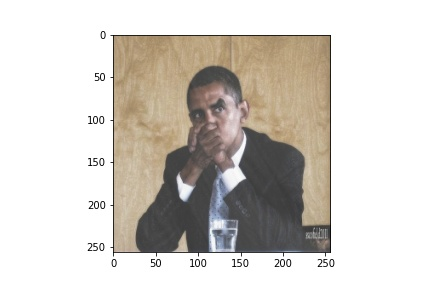

In [76]:
display.display(display.Image("stylized_image.jpg"))